<a href="https://colab.research.google.com/github/claireyung/colabfiredrake/blob/main/Copy_of_ice_ocean_tutorial1_ice_pump.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This magic makes plots appear in the browser
%matplotlib inline
import matplotlib.pyplot as plt

# Load Firedrake on Colab
try:
    import firedrake
except ImportError:
    !wget "https://github.com/thwaitesproject/tutorials/releases/latest/download/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

try:
    import thwaites
except:
    !pip install git+https://github.com/thwaitesproject/thwaites
    import thwaites



In [3]:
from thwaites import *
from thwaites.utility import get_top_boundary, cavity_thickness
from firedrake.petsc import PETSc
from firedrake import FacetNormal
import numpy as np

<h1>Ice pumps</h1>

In this tutorial we are diving deep beneath the ice into ice shelf ocean cavities!

Ice shelves are the floating tongues of ice that can form where large glaciers flow into the ocean. (Have a look at: https://www.antarctica.gov.au/about-antarctica/weather-and-climate/climate-change/ice-shelves/ !)

Increased basal melting beneath ice shelves, due to increased ocean heat, is thought to be the main cause for ice loss in West Antarctica. Wherever ice shelves are topographically confined, they provide buttressing forces to the grounded glaciers. When ice shelves thin, a decrease in buttressing can lead to an increase in ice flow speeds and hence the rate at which grounded ice is lost increases.

Today we are going to model a very simple overturning flow that can occur in ice shelf cavities, known as an 'Ice Pump' mechanism. Melting ice injects buoyant, fresh water into the domain, which in turn drives overturning ocean circulation within the cavity. The freezing point of water decreases with depth so, in some cases, ice that melts at depth in the cavity can refreeze closer to the ocean surface, thus transporting ice up the underside of the ice shelf. We will see some frazil ice effects in the next tutorial hopefully!



<h2>Some equations!</h2>

One of the key motivations behind the model here is to treat vertical dynamics in the same way as horizontal dynamics, when the mesh cells become close to isotropic, on fully unstructured meshes.  This means we solve the full incompressible Navier-Stokes equations for velocity and pressure, and we do not make the hydrostatic approximation.

Conservation of momentum (in strong form) for a rotating fluid under the Boussinesq approximation can be written as
\begin{equation}
\dfrac{\partial \textbf{u}}{\partial t} + \textbf{u} \cdot \nabla\textbf{u} + 2 \boldsymbol{\Omega}  \times \textbf{u}  = - \dfrac{1}{\rho_0} \nabla p + \nabla \cdot \boldsymbol{\tau} + \textbf{F},
\end{equation}
where
\begin{equation}
    \boldsymbol{\tau} = \boldsymbol{\nu} \cdot \left[\nabla \textbf{u} + (\nabla \textbf{u})^T\right].
\end{equation}
The velocity, $\textbf{u} = (u, v, w)^T$, and pressure, $p$, can be solved for using the continuity equation as a constraint to enforce the incompressibility condition
\begin{equation}
\nabla \cdot \textbf{u} = 0.
\end{equation}


The key differences between Navier-Stokes and Stokes flow for mantle dynamics is that now we are interested in the inertial terms! i.e. we keep the time derivative of velocity, the advection term and the Coriolis force accounting for the rotation of Earth. Let's neglect Coriolis for now as we will limit ourselves to 2D examples.


If we focus on the advection term integrating by parts and testing with a test function, $\boldsymbol{\phi}$, gives



\begin{align}
\label{eq:advection}
    A = \int_{\Omega} - \textbf{u} \cdot \left[\nabla \cdot
   (\textbf{u} \otimes \boldsymbol{\phi})\right] \,dx  +
   \int_{\Gamma} (\tilde{\textbf{u}} \cdot \boldsymbol{\phi} )
   ( \textbf{u} \cdot \textbf{n})  \,ds,
\end{align}

and the corresponding Firedrake code (from: https://github.com/thwaitesproject/thwaites/blob/master/thwaites/momentum_equation.py) is given in the cell below. N.b. the Thwaites repo and G-ADOPT are very similar!

In [4]:
from thwaites.equations import BaseTerm

class MomentumAdvectionTerm(BaseTerm):
    r"""
    Momentum advection term (non-conservative): u \dot \grad(u)
    """
    def residual(self, test, trial, trial_lagged, fields, bcs):
        u_adv = trial_lagged
        phi = test
        n = self.n
        u = trial

        F = -dot(u, div(outer(phi, u_adv)))*self.dx

        for id, bc in bcs.items():
            if 'u' in bc:
                u_in = bc['u']
            elif 'un' in bc:
                u_in = bc['un'] * n  # this implies u_t=0 on the inflow
            else:
                u_in = zero(self.dim)
            F += conditional(dot(u_adv, n) < 0,
                             dot(phi, u_in)*dot(u_adv, n),
                             dot(phi, u)*dot(u_adv, n)) * self.ds(id)

        if not (is_continuous(self.trial_space) and normal_is_continuous(u_adv)):
            # s=0: u.n(-)<0  =>  flow goes from '+' to '-' => '+' is upwind
            # s=1: u.n(-)>0  =>  flow goes from '-' to '+' => '-' is upwind
            s = 0.5*(sign(dot(avg(u), n('-'))) + 1.0)
            u_up = u('-')*s + u('+')*(1-s)
            F += dot(u_up, (dot(u_adv('+'), n('+'))*phi('+') + dot(u_adv('-'), n('-'))*phi('-'))) * self.dS

        return -F

<h2>Melt Parameterisation **</h2>

** If you are interested!

Melt rates are calculated based on conservation of heat and salt at the ice-ocean boundary and under the assumption that the boundary is at the freezing point, commonly referred to as the `three-equation' melt parameterisation.
Conservation of heat is expressed as
\begin{equation}
Q_i^T - Q_w^T  =  Q_{{latent}}^T,
\end{equation}
where the latent heat term, $Q_{{latent}}^T $ is given by
\begin{equation}
Q_{{latent}}^T   =  -\rho_0 w_b L_f,
\end{equation}
with $w_b$ the unknown melt rate (melting: $w_b > 0$, freezing: $w_b < 0$) and $L_f = 3.34 \times 10 ^{5} \, {J kg}^{-1}$ is the latent heat of fusion. The conductive heat flux into the ice, $Q_i^T$ is
\begin{equation}
Q_i^T = -\rho_i c_{pi} w_b (T_i - T_b),
\end{equation}
where $\rho_i = 920 \, {kg m}^{-3}$ is the density of ice, $c_{pi} = 2000 \, {J kg}^{-1} \, {K} ^{-1}$ is the specific heat capacity of ice, $T_i$ is the far field ice temperature, taken to be $-20 \, ^\circ {C}$ and $T_b$ is the unknown temperature at the ice-ocean boundary.  
The turbulent heat flux from the ocean to the ice, $Q_w^T$ is given by
\begin{equation}
Q_w^T = -\rho_0 c_p \gamma_T (T_b - T_w),
\end{equation}
where $c_p = 3974 \, {J kg}^{-1} \, {K} ^{-1}$ is the specific heat capacity of water and $\gamma_T$ the turbulent thermal exchange velocity. Commonly $\gamma_T$ is expressed as $\Gamma_T u^{\star}$, where $\Gamma_T$ is a dimensionless constant and $u^{\star} = \sqrt{C_D}|u|$ is the friction velocity.

The conservation of salt is similar to heat and is given by
\begin{equation}
Q_i^S - Q_w^S  =  Q_{{brine}}^S,
\end{equation}
where the fresh water melt flux $Q_{{brine}}^S$ is given by
\begin{equation}
Q_{brine}^S   =  -\rho_0 w_b (S_i - S_b),
\end{equation}
 and where $S_i$ is the salinity of the ice, which is taken to be zero, and $S_b$ is the unknown salinity at the ice base. The turbulent salt flux across the ocean boundary layer $Q_w^S$ can be written as
\begin{equation}
Q_w^S = -\rho_0 \gamma_S (S_b - S_w),
\end{equation}
where $\gamma_S$ is the turbulent salinity exchange velocity, analogous to $\gamma_T$ and as before we take $S_w$ as the value of salinity at the edge of the computational domain offset from the ice-ocean boundary. The diffusive flux of salt into the ice, $Q_i^S$ is assumed to be zero.
The ice-ocean boundary temperature, $T_b$ is assumed to be at the freezing point
\begin{equation}
T_b  =  a S_b + b + c P_b,
\end{equation}
where $a = -5.73 \times 10 ^{-2} \, {}^\circ{C}$, $b = 8.32 \times 10 ^{-2} \, {}^\circ {C}$ and $c = -7.53 \times 10 ^{-8} \, {}^\circ{C Pa}^{-1} $ are the coefficients obtained from linearisation of the nonlinear freezing point equation \citep{millero_freezing_1978} using the values from \citet{asay-davis_experimental_2016} and $P_b$ is the pressure at the boundary. This means there are now three equations to solve for the three unknowns, $w_b$, $S_b$, and $T_b$; the melt rate and the salinity and temperature values at the boundary, respectively. Rearranging the equations gives a quadratic equation for $S_b$, and the positive value is taken as the solution. By using the form of the heat and salt flux, Robin boundary conditions for temperature and salinity can be imposed as shown in the Figure below according to
\begin{equation}
\Phi_T = \kappa \textbf{n} \cdot \nabla T = (\gamma_T + w_b)(T_b - T_w),
\end{equation}
and
\begin{equation}
\Phi_S = \kappa \textbf{n} \cdot \nabla S = (\gamma_S + w_b)(S_b - S_w),
\end{equation}

If you are interested in the algebra have a look here: https://github.com/thwaitesproject/thwaites/blob/master/thwaites/meltrate_param.py

![melt_param_extruded_scalars_whitefill.png](https://github.com/thwaitesproject/tutorials/blob/main/melt_param_extruded_scalars_whitefill.png?raw=1)

<h2>Model Domain</h2>


The model domain is a 2D vertical slice through an idealised ice shelf cavity.
The domain is 10 km long, with a horizontal grid resolution of 500 m. The ice shelf draft linearly increases from a depth of 598 m at the grounding line to a depth of 498 m at the right-hand boundary. Bathymetry is constant throughout the domain at 600 m depth. Vertical grid resolution is 2 m, except along the top boundary where grid resolution decreases to 0.5 m in an alternating pattern designed to match the slope of the ice shelf.  This choice of mesh is motivated by MITgcm’s $z$-coordinate grid.



In [6]:
#  Generate mesh
L = 10E3
H1 = 2.
H2 = 102.
dy = 50.0
ny = round(L/dy)
#nz = 50
dz = 1.0


try:
    # create mesh
    mesh = Mesh("./coarse.msh")
except:
    # load mesh for colab if not already loaded
    !wget https://raw.githubusercontent.com/thwaitesproject/tutorials/main/coarse.msh
    mesh = Mesh("./coarse.msh")

PETSc.Sys.Print("Mesh dimension ", mesh.geometric_dimension())


# shift z = 0 to surface of ocean. N.b z = 0 is outside domain.
PETSc.Sys.Print("Length of lhs", assemble(Constant(1.0)*ds(1, domain=mesh)))

PETSc.Sys.Print("Length of rhs", assemble(Constant(1.0)*ds(2, domain=mesh)))

PETSc.Sys.Print("Length of bottom", assemble(Constant(1.0)*ds(3, domain=mesh)))

PETSc.Sys.Print("Length of top", assemble(Constant(1.0)*ds(4, domain=mesh)))

x, z = SpatialCoordinate(mesh)
#xs*1/100 + 2 + 10*np.sin(xs/(25))
Vc = mesh.coordinates.function_space()
f = Function(Vc).interpolate(as_vector([x,  z + z/(x/100 + 2)*10*sin(x/25)]))
mesh.coordinates.assign(f)

water_depth = 600.0
mesh.coordinates.dat.data[:, 1] -= water_depth


print("You have Comm WORLD size = ", mesh.comm.size)
print("You have Comm WORLD rank = ", mesh.comm.rank)

y, z = SpatialCoordinate(mesh)


Mesh dimension  2
Length of lhs 1.9999999999999976
Length of rhs 101.99999999999997
Length of bottom 10000.0
Length of top 10000.499987500625
You have Comm WORLD size =  1
You have Comm WORLD rank =  0


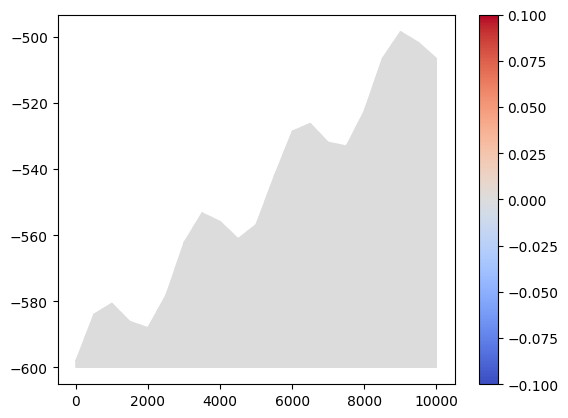

In [7]:
# Set up function spaces
V = VectorFunctionSpace(mesh, "DG", 1)  # velocity space
m = Function(V)

fig, axes = plt.subplots()
collection = tripcolor(m, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

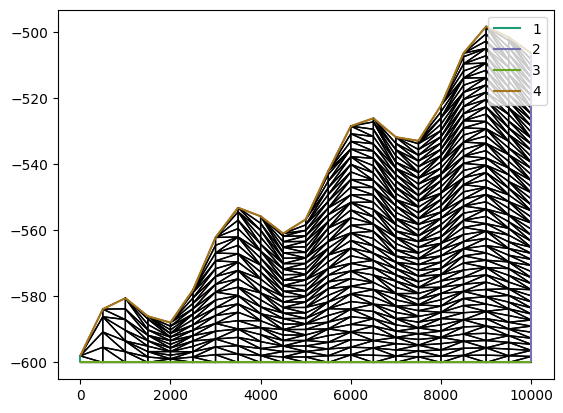

In [8]:

fig, axes = plt.subplots()
triplot(mesh, axes=axes)
axes.legend()
fig.show()

<h2>Functions and Function Spaces</h2>

Now we need to set up some function spaces and corresponding functions. We use a P1DG-P2 discretisation for velocity and pressure, and P1DG is used for the tracers.

In [9]:
# Set up function spaces
V = VectorFunctionSpace(mesh, "DG", 1)  # velocity space
W = FunctionSpace(mesh, "CG", 2)  # pressure space
M = MixedFunctionSpace([V, W])

# scalar function space.
K = FunctionSpace(mesh, "DG", 1)    # scalar function space


##########

# Set up functions
m = Function(M)
v_, p_ = m.subfunctions  # function: velocity, pressure
v, p = split(m)  # expression: velocity, pressure
v_._name = "v_velocity"
p_._name = "perturbation pressure"


rho = Function(K, name="density")
temp = Function(K, name="temperature")
sal = Function(K, name="salinity")
melt = Function(K, name="melt rate")
Q_mixed = Function(K, name="ocean heat flux")
Q_ice = Function(K, name="ice heat flux")
Q_latent = Function(K, name="latent heat")
Q_s = Function(K, name="ocean salt flux")
Tb = Function(K, name="boundary freezing temperature")
Sb = Function(K, name="boundary salinity")
full_pressure = Function(M.sub(1), name="full pressure")

##########

Here we initialise with constant values of 1 $^\circ$C and salinity with 34.4. These values are used later to restore the region over the last 600 m, with a restoring period of 1 day.

In [10]:
dump_file = "/data/2d_mitgcm_comparison/14.04.20_3_eq_param_ufricHJ99_dt30.0_dtOutput30.0_T900.0_ip50.0_tres86400.0_Kh0.001_Kv0.0001_dy50_dz1_closed_iterative/dump_step_30.h5"

DUMP = False
if DUMP:
    with DumbCheckpoint(dump_file, mode=FILE_UPDATE) as chk:
        # Checkpoint file open for reading and writing
        chk.load(v_, name="v_velocity")
        chk.load(p_, name="perturbation_pressure")
        #chk.load(u, name="u_velocity")
        chk.load(sal, name="salinity")
        chk.load(temp, name="temperature")

        # from holland et al 2008b. constant T below 200m depth. varying sal.
        T_200m_depth = 1.0

        S_200m_depth = 34.4
        #S_bottom = 34.8
        #salinity_gradient = (S_bottom - S_200m_depth) / -H2
        #S_surface = S_200m_depth - (salinity_gradient * (H2 - water_depth))  # projected linear slope to surface.

        T_restore = Constant(T_200m_depth)
        S_restore = Constant(S_200m_depth) #S_surface + (S_bottom - S_surface) * (z / -water_depth)


else:
    # Assign Initial conditions
    v_init = zero(mesh.geometric_dimension())
    v_.assign(v_init)


    T_200m_depth = 1.0


    #S_bottom = 34.8
    #salinity_gradient = (S_bottom - S_200m_depth) / -H2
    S_surface = 34.4 #S_200m_depth - (salinity_gradient * (H2 - water_depth))  # projected linear slope to surface.

    T_restore = Constant(T_200m_depth)
    S_restore = Constant(S_surface) #S_surface + (S_bottom - S_surface) * (z / -water_depth)

    temp_init = T_restore
    temp.interpolate(temp_init)

    sal_init = Constant(34.4)
    #sal_init = S_restore
    sal.interpolate(sal_init)



<h2>Equations and Parameters</h2>

Let's set up some equations

In [11]:
# Set up equations
mom_eq = MomentumEquation(M.sub(0), M.sub(0))
cty_eq = ContinuityEquation(M.sub(1), M.sub(1))
temp_eq = ScalarAdvectionDiffusionEquation(K, K)
sal_eq = ScalarAdvectionDiffusionEquation(K, K)


Let's define some more parameters. Horizontal viscosity is 0.25 m$^2$/s and vertical viscosity is $1\times 10^{-3}$ m$^2$/s, matching the grid aspect ratio. Diffusivity for both tracers is set equal to viscosity.  The timestep is 300 s.

In [12]:
# Terms for equation fields

# momentum source: the buoyancy term Boussinesq approx. From mitgcm default
T_ref = Constant(0.0)
S_ref = Constant(35)
beta_temp = Constant(2.0E-4)
beta_sal = Constant(7.4E-4)
g = Constant(9.81)
mom_source = as_vector((0., -g))*(-beta_temp*(temp - T_ref) + beta_sal * (sal - S_ref))

rho0 = 1030.
rho.interpolate(rho0*(1.0-beta_temp * (temp - T_ref) + beta_sal * (sal - S_ref)))
# coriolis frequency f-plane assumption at 75deg S. f = 2 omega sin (lat) = 2 * 7.2921E-5 * sin (-75 *2pi/360)
#f = Constant(-1.409E-4)

kappa_h = Constant(0.25)
kappa_v = Constant(kappa_h/250.)

kappa = as_tensor([[kappa_h, 0], [0, kappa_v]])

kappa_temp = kappa
kappa_sal = kappa
mu = kappa

ip_factor = Constant(50.)
restoring_time = 86400.

# define time steps
dt = 300
T = 86400*1  # run for 1 day, steady state by ~40 days
output_dt = 3600*6  # output every 6 hours
output_step = output_dt/dt


In [13]:
# Scalar source/sink terms at boundary.
absorption_factor = Constant(1.0/restoring_time)
sponge_fraction = 0.06  # fraction of domain where sponge
# Temperature source term
source_temp = conditional(y > (1.0-sponge_fraction) * L,
                          ((y - (1.0-sponge_fraction) * L)/(L * sponge_fraction)) * absorption_factor * T_restore,
                          0.0)

# Salinity source term
source_sal = conditional(y > (1.0-sponge_fraction) * L,
                         ((y - (1.0-sponge_fraction) * L)/(L * sponge_fraction)) * absorption_factor * S_restore,
                         0.0)

# Temperature absorption term
absorp_temp = conditional(y > (1.0-sponge_fraction) * L,
                          ((y - (1.0-sponge_fraction) * L)/(L * sponge_fraction)) * absorption_factor,
                          0.0)

# Salinity absorption term
absorp_sal = conditional(y > (1.0-sponge_fraction) * L,
                         ((y - (1.0-sponge_fraction) * L)/(L * sponge_fraction)) * absorption_factor,
                         0.0)



Provide some fields dictionaries so that each set of equation knows about the other relevant fields

In [14]:
ip_alpha = Constant(3*dy/dz*2*ip_factor)
# Equation fields
vp_coupling = [{'pressure': 1}, {'velocity': 0}]
vp_fields = {'viscosity': mu, 'source': mom_source, 'interior_penalty': ip_alpha}
temp_fields = {'diffusivity': kappa_temp, 'velocity': v, 'interior_penalty': ip_alpha, 'source': source_temp,
               'absorption coefficient': absorp_temp}
sal_fields = {'diffusivity': kappa_sal, 'velocity': v, 'interior_penalty': ip_alpha, 'source': source_sal,
              'absorption coefficient': absorp_sal}


<h2>Melt Parameterisation</h2>
Set up the melt rate parameterisation!

In [15]:
# Get expressions used in melt rate parameterisation
mp = ThreeEqMeltRateParam(sal, temp, p, z, velocity=pow(dot(v, v), 0.5), HJ99Gamma=True)

# n.b. apologies for the funky output - it will make it easier for the MMS example later.
# This is what Firedrake code looks like at a symbolic level before the code generation

<class 'ufl.algebra.Division'>
(-1 * (-1 * w₄₅ * 3974.0 * (0.0025 * ((((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) > (0.001)) ? ((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) : (0.001)) ** 2) ** 0.5 / 73.03202715077265 + 334000.0 * -1 * (0.0025 * ((((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) > (0.001)) ? ((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) : (0.001)) ** 2) ** 0.5 / 2261.691111799595 + (0.0832 + -7.53e-08 * -10084.68 * x[1]) * 3974.0 * (0.0025 * ((((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) > (0.001)) ? ((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) : (0.001)) ** 2) ** 0.5 / 73.03202715077265 + -0.0573 * 2000.0 * w₄₇ * (0.0025 * ((((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) > (0.001)) ? ((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) : (0.001)) ** 2) ** 0.5 / 2261.691111799595 + -1 * (0.0832 + -7.53e-08 * -10084.68 * x[1]) * 2000.0 * (0.0025 * ((((([w⃗₃₇[0], w⃗₃₇[1]]) . ([w⃗₃₇[0], w⃗₃₇[1]])) ** 0.5) > (

<h2>Boundary conditions</h2>
Here we specify boundary conditions

In [16]:
# Boundary conditions
# top boundary: no normal flow, drag flowing over ice
# bottom boundary: no normal flow, drag flowing over bedrock
# grounding line wall (LHS): no normal flow
# open ocean (RHS): no normal flow but below is a method for calcualting hydrostatic pressure to account for density differences

# WEAKLY Enforced BCs
n = FacetNormal(mesh)
Temperature_term = -beta_temp * ((T_restore-T_ref) * z)
Salinity_term = beta_sal * ((S_restore - S_ref) * z) # ((S_bottom - S_surface) * (pow(z, 2) / (-2.0*water_depth)) + (S_surface-S_ref) * z)
stress_open_boundary = -n*-g*(Temperature_term + Salinity_term)
no_normal_flow = 0.
ice_drag = 0.0097

vp_bcs = {4: {'un': no_normal_flow, 'drag': ice_drag}, 2: {'un': no_normal_flow},
          3: {'un': no_normal_flow, 'drag': 0.0025}, 1: {'un': no_normal_flow}}


temp_bcs = {4: {'flux': -mp.T_flux_bc}}

sal_bcs = {4: {'flux': -mp.S_flux_bc}}

# STRONGLY Enforced BCs
# Let's ignore them for now
strong_bcs = []

<h2>Solver parameters</h2>

Let's use mumps for most of the work use the pressure projection method to split the velocity-pressure solve into two parts

In [17]:
# Solver parameters
mumps_solver_parameters = {
    'snes_monitor': None,
    'snes_type': 'ksponly',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
    'pc_factor_mat_solver_type': 'mumps',
    'mat_type': 'aij',
    'snes_max_it': 100,
    'snes_rtol': 1e-8,
    'snes_atol': 1e-6,
}

pressure_projection_solver_parameters = {
        'snes_type': 'ksponly',
        'ksp_type': 'preonly',  # we solve the full schur complement exactly, so no need for outer krylov
        'mat_type': 'matfree',
        'pc_type': 'fieldsplit',
        'pc_fieldsplit_type': 'schur',
        'pc_fieldsplit_schur_fact_type': 'full',
        # velocity mass block:
        'fieldsplit_0': {
            'ksp_type': 'gmres',
            'pc_type': 'python',
            'pc_python_type': 'firedrake.AssembledPC',
            'ksp_converged_reason': None,
            'assembled_ksp_type': 'preonly',
            'assembled_pc_type': 'bjacobi',
            'assembled_sub_pc_type': 'ilu',
            },
        # schur system: explicitly assemble the schur system
        # this only works with pressureprojectionicard if the velocity block is just the mass matrix
        # and if the velocity is DG so that this mass matrix can be inverted explicitly
        'fieldsplit_1': {
            'ksp_type': 'preonly',
            'pc_type': 'python',
            'pc_python_type': 'thwaites.AssembledSchurPC',
            'schur_ksp_type': 'cg',
            'schur_ksp_max_it': 1000,
            'schur_ksp_rtol': 1e-7,
            'schur_ksp_atol': 1e-9,
            'schur_ksp_converged_reason': None,
            'schur_pc_type': 'gamg',
            'schur_pc_gamg_threshold': 0.01
            },
        }

vp_solver_parameters = pressure_projection_solver_parameters
u_solver_parameters = mumps_solver_parameters
temp_solver_parameters = mumps_solver_parameters
sal_solver_parameters = mumps_solver_parameters


<h2>Timesteppers</h2>
Similar to G-ADOPT let's call some time steppers

In [18]:
# Set up time stepping routines

vp_timestepper = PressureProjectionTimeIntegrator([mom_eq, cty_eq], m, vp_fields, vp_coupling, dt, vp_bcs,
                                                          solver_parameters=vp_solver_parameters,
                                                          predictor_solver_parameters=u_solver_parameters,
                                                          picard_iterations=1,
                                                          pressure_nullspace=VectorSpaceBasis(constant=True))

# performs pseudo timestep to get good initial pressure
# this is to avoid inconsistencies in terms (viscosity and advection) that
# are meant to decouple from pressure projection, but won't if pressure is not initialised
# do this here, so we can see the initial pressure in pressure_0.pvtu
if not DUMP:
    # should not be done when picking up
    vp_timestepper.initialize_pressure()


temp_timestepper = DIRK33(temp_eq, temp, temp_fields, dt, temp_bcs, solver_parameters=temp_solver_parameters)
sal_timestepper = DIRK33(sal_eq, sal, sal_fields, dt, sal_bcs, solver_parameters=sal_solver_parameters)


firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed
/usr/local/lib/python3.10/dist-packages/firedrake/functionspaceimpl.py:125: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/firedrake/function.py:319: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


  0 SNES Function norm 1.807434677361e+04 
  1 SNES Function norm 2.451921338848e-12 
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1


/usr/local/lib/python3.10/dist-packages/firedrake/functionspaceimpl.py:125: FutureWarning: The .split() method is deprecated, please use the .subfunctions property instead
  warnings.warn("The .split() method is deprecated, please use the .subfunctions property instead", category=FutureWarning)


Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_1_schur_ solve converged due to CONVERGED_RTOL iterations 17
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1


<h2>Outputs</h2>

In [19]:
# Set up folder
folder = "./ice_pump/"
# Output files for velocity, pressure, temperature and salinity
v_file = File(folder+"vw_velocity.pvd")
v_file.write(v_)

p_file = File(folder+"pressure.pvd")
p_file.write(p_)

#u_file = File(folder+"u_velocity.pvd")
#u_file.write(u)

t_file = File(folder+"temperature.pvd")
t_file.write(temp)

s_file = File(folder+"salinity.pvd")
s_file.write(sal)

rho_file = File(folder+"density.pvd")
rho_file.write(rho)

m_file = File(folder+"melt.pvd")
m_file.write(melt)

<h2>Timestepping</h2>
Let's go!

In [20]:
# Begin time stepping
t = 0.0
step = 0

while t < T - 0.5*dt:
    vp_timestepper.advance(t)
    temp_timestepper.advance(t)
    sal_timestepper.advance(t)


    step += 1
    t += dt


    if step % output_step == 0:
        # dumb checkpoint for starting from last timestep reached
        with DumbCheckpoint(folder+"dump.h5", mode=FILE_UPDATE) as chk:
            # Checkpoint file open for reading and writing
            chk.store(v_, name="v_velocity")
            chk.store(p_, name="perturbation_pressure")
            chk.store(temp, name="temperature")
            chk.store(sal, name="salinity")

        # Update melt rate functions
        Q_ice.interpolate(mp.Q_ice)
        Q_mixed.interpolate(mp.Q_mixed)
        Q_latent.interpolate(mp.Q_latent)
        Q_s.interpolate(mp.S_flux_bc)
        melt.interpolate(mp.wb)
        Tb.interpolate(mp.Tb)
        Sb.interpolate(mp.Sb)
        full_pressure.interpolate(mp.P_full)

        # Update density for plotting
        rho.interpolate(rho0*(1.0-beta_temp * (temp - T_ref) + beta_sal * (sal - S_ref)))



         # Write out files
        v_file.write(v_)
        p_file.write(p_)
        #u_file.write(u)
        t_file.write(temp)
        s_file.write(sal)
        rho_file.write(rho)

        # Write melt rate functions
        m_file.write(melt)
        time_str = str(step)
        PETSc.Sys.Print("t=", t)
        PETSc.Sys.Print("integrated melt =", assemble(melt * ds(4)))
    if step % (output_step * 24) == 0:
        with DumbCheckpoint(folder+"dump_step_{}.h5".format(step), mode=FILE_CREATE) as chk:
            # Checkpoint file open for reading and writing at regular interval
            chk.store(v_, name="v_velocity")
            chk.store(p_, name="perturbation_pressure")
            #chk.store(u, name="u_velocity")
            chk.store(temp, name="temperature")
            chk.store(sal, name="salinity")


  0 SNES Function norm 1.749978734332e-03 
  1 SNES Function norm 1.983424537508e-14 
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_1_schur_ solve converged due to CONVERGED_ATOL iterations 7
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
  0 SNES Function norm 2.693816579509e-03 
  1 SNES Function norm 5.564285808214e-11 
  0 SNES Function norm 1.890962552531e-03 
  1 SNES Function norm 6.888162452586e-11 
  0 SNES Function norm 3.066000475716e-03 
  1 SNES Function norm 6.248177036580e-11 
  0 SNES Function norm 9.669077320389e-04 
  1 SNES Function norm 2.496553266934e-09 
  0 SNES Function norm 6.788138862125e-04 
  1 SNES Function norm 2.954280597389e-09 
  0 SNES Function norm 1.100400203675e-03 
  1 

/usr/local/lib/python3.10/dist-packages/firedrake/checkpointing.py:98: DeprecationWarning: DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.",


t= 21600.0
integrated melt = 0.00017728922259035244
  0 SNES Function norm 3.118738045651e-02 
  1 SNES Function norm 3.161687112900e-09 
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_1_schur_ solve converged due to CONVERGED_ATOL iterations 11
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
  0 SNES Function norm 3.913057370265e-06 
  1 SNES Function norm 7.022783056346e-11 
  0 SNES Function norm 3.895281616271e-06 
  1 SNES Function norm 6.619194834713e-11 
  0 SNES Function norm 3.877318441099e-06 
  1 SNES Function norm 6.592902200267e-11 
  0 SNES Function norm 1.404740040174e-06 
  1 SNES Function norm 3.050585265611e-09 
  0 SNES Function norm 1.398393856312e-06 
  1 SNES Function norm 3.094313884681

/usr/local/lib/python3.10/dist-packages/firedrake/checkpointing.py:98: DeprecationWarning: DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.",


t= 43200.0
integrated melt = 0.0002154368505016984
  0 SNES Function norm 4.768762272956e-02 
  1 SNES Function norm 8.696358597993e-10 
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_1_schur_ solve converged due to CONVERGED_ATOL iterations 12
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
  0 SNES Function norm 5.756131461246e-06 
  1 SNES Function norm 6.572073682580e-11 
  0 SNES Function norm 5.745423011642e-06 
  1 SNES Function norm 6.332273009387e-11 
  0 SNES Function norm 5.748285531255e-06 
  1 SNES Function norm 6.136705444609e-11 
  0 SNES Function norm 2.066304046602e-06 
  1 SNES Function norm 3.079419531672e-09 
  0 SNES Function norm 2.062536410878e-06 
  1 SNES Function norm 3.010381556740e

/usr/local/lib/python3.10/dist-packages/firedrake/checkpointing.py:98: DeprecationWarning: DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.",


t= 64800.0
integrated melt = 0.0003169935658238527
  0 SNES Function norm 8.678222496387e-02 
  1 SNES Function norm 4.174453483756e-09 
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_1_schur_ solve converged due to CONVERGED_ATOL iterations 12
    Linear PressureProjectionTimeIntegrator-MomentumEquation-ContinuityEquation_fieldsplit_0_ solve converged due to CONVERGED_RTOL iterations 1
  0 SNES Function norm 1.082271081333e-05 
  1 SNES Function norm 6.318781296817e-11 
  0 SNES Function norm 1.080732489837e-05 
  1 SNES Function norm 6.352730423123e-11 
  0 SNES Function norm 1.081194188807e-05 
  1 SNES Function norm 6.221760573068e-11 
  0 SNES Function norm 3.884720701819e-06 
  1 SNES Function norm 3.008559351241e-09 
  0 SNES Function norm 3.879588333873e-06 
  1 SNES Function norm 2.984795545591e

/usr/local/lib/python3.10/dist-packages/firedrake/checkpointing.py:98: DeprecationWarning: DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.
  warnings.warn("DumbCheckpoint class will soon be deprecated; use CheckpointFile class instead.",


t= 86400.0
integrated melt = 0.0005029524236251279


<h1>Exercises</h1>

1) Try running the simulation for 1 day and plot the outputs e.g. temperature field and velocity. What do you notice about the flow and the temperature (and salinity) stratification?

2) Try adjusting the viscosity and/or diffusivity, how does this change the solution?



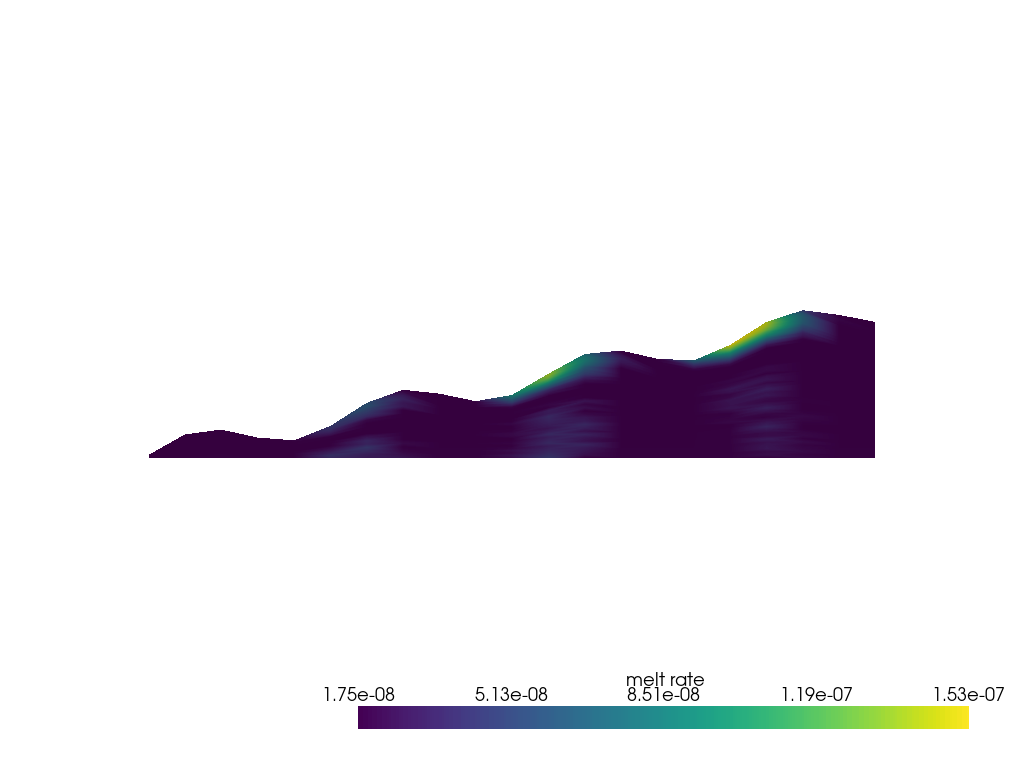

In [6]:
temp_data = pv.read("ice_pump/melt_4.vtu")
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data)
plotter.camera_position = "xy"
plotter.set_scale(yscale=20)
plotter.show(jupyter_backend="static", interactive=False)

<ipython-input-5-7a3c04659483>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  boring_cmap = plt.cm.get_cmap("viridis", 25)


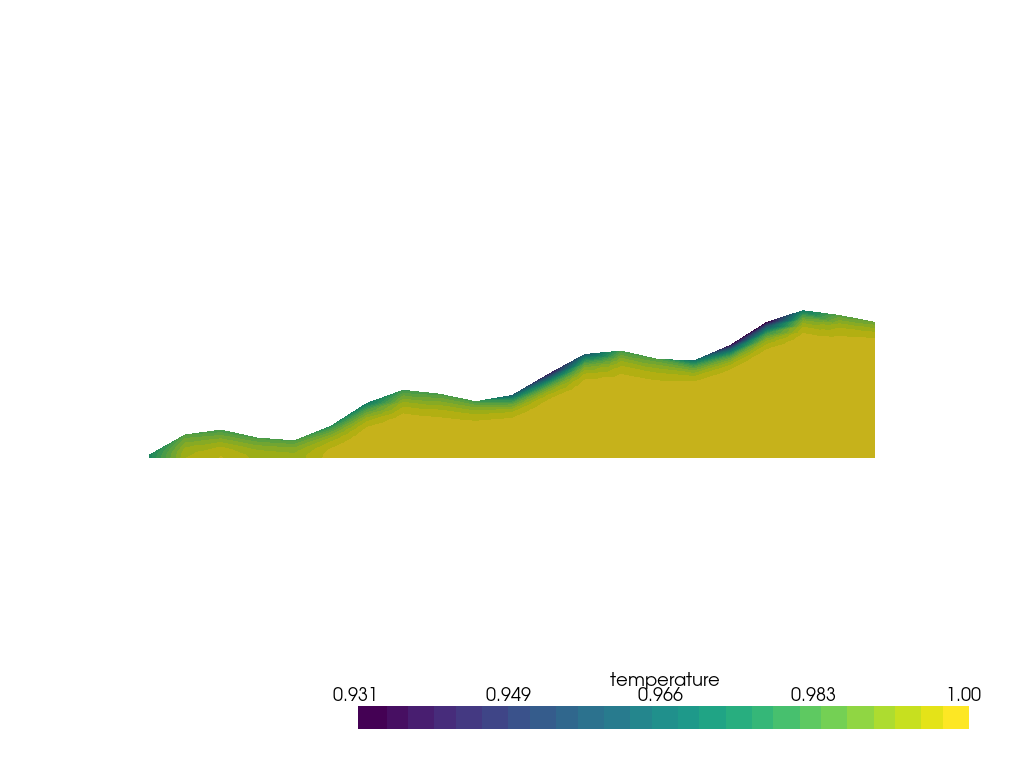

In [5]:
import pyvista as pv

temp_data = pv.read("ice_pump/temperature_4.vtu")

boring_cmap = plt.cm.get_cmap("viridis", 25)
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(temp_data, cmap=boring_cmap)
plotter.camera_position = "xy"
plotter.set_scale(yscale=20)
plotter.show(jupyter_backend="static", interactive=False)